In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
from binance.client import Client
from binance import enums
api_key = "your key"
api_secret = "your secret"
client = Client(api_key, api_secret)

In [172]:
import cryptoz
from cryptoz import stats, utils, plot

# params

In [3]:
pairs = [
    'BNB/USDT',
    'BTC/USDT',
    'XRP/USDT', 
    'ETH/USDT', 
    'ADA/USDT', 
    'XLM/USDT', 
    'XVG/USDT', 
    'LTC/USDT', 
    'IOTA/USDT', 
    'QTUM/USDT', 
    'NEO/USDT', 
    'DASH/USDT', 
    'ETC/USDT', 
    'LSK/USDT', 
    'XMR/USDT', 
    'OMG/USDT', 
    'STRAT/USDT', 
    'ZEC/USDT',
    'BCC/USDT'
]

In [4]:
interval = enums.KLINE_INTERVAL_1HOUR
last_window = pd.Timedelta(days=3)

# data

In [6]:
from cryptoz.exchanges.binance import Binance

binance = Binance(client)

ohlc = binance.get_ohlc(pairs, interval=interval)

19 pairs:
BNB/USDT.. done
BTC/USDT.. done
XRP/USDT.. cross BTC/USDT.. done
ETH/USDT.. done
ADA/USDT.. cross BTC/USDT.. done
XLM/USDT.. cross BTC/USDT.. done
XVG/USDT.. cross BTC/USDT.. done
LTC/USDT.. done
IOTA/USDT.. cross BTC/USDT.. done
QTUM/USDT.. cross BTC/USDT.. done
NEO/USDT.. done
DASH/USDT.. cross BTC/USDT.. done
ETC/USDT.. cross BTC/USDT.. done
LSK/USDT.. cross BTC/USDT.. done
XMR/USDT.. cross BTC/USDT.. done
OMG/USDT.. cross BTC/USDT.. done
STRAT/USDT.. cross BTC/USDT.. done
ZEC/USDT.. cross BTC/USDT.. done
BCC/USDT.. done


In [288]:
orderbooks = binance.get_orderbooks(pairs)

19 pairs:
BNB/USDT.. done
BTC/USDT.. done
XRP/USDT.. cross BTC/USDT.. done
ETH/USDT.. done
ADA/USDT.. cross BTC/USDT.. done
XLM/USDT.. cross BTC/USDT.. done
XVG/USDT.. cross BTC/USDT.. done
LTC/USDT.. done
IOTA/USDT.. cross BTC/USDT.. done
QTUM/USDT.. cross BTC/USDT.. done
NEO/USDT.. done
DASH/USDT.. cross BTC/USDT.. done
ETC/USDT.. cross BTC/USDT.. done
LSK/USDT.. cross BTC/USDT.. done
XMR/USDT.. cross BTC/USDT.. done
OMG/USDT.. cross BTC/USDT.. done
STRAT/USDT.. cross BTC/USDT.. done
ZEC/USDT.. cross BTC/USDT.. done
BCC/USDT.. done


# basics

## klines

    count         mean          std      min       25%        50%         75%  \
0  1368.0  1089.300604  3180.951828  0.13641  3.765159  34.496493  647.583877   

       max  
0  15349.0  


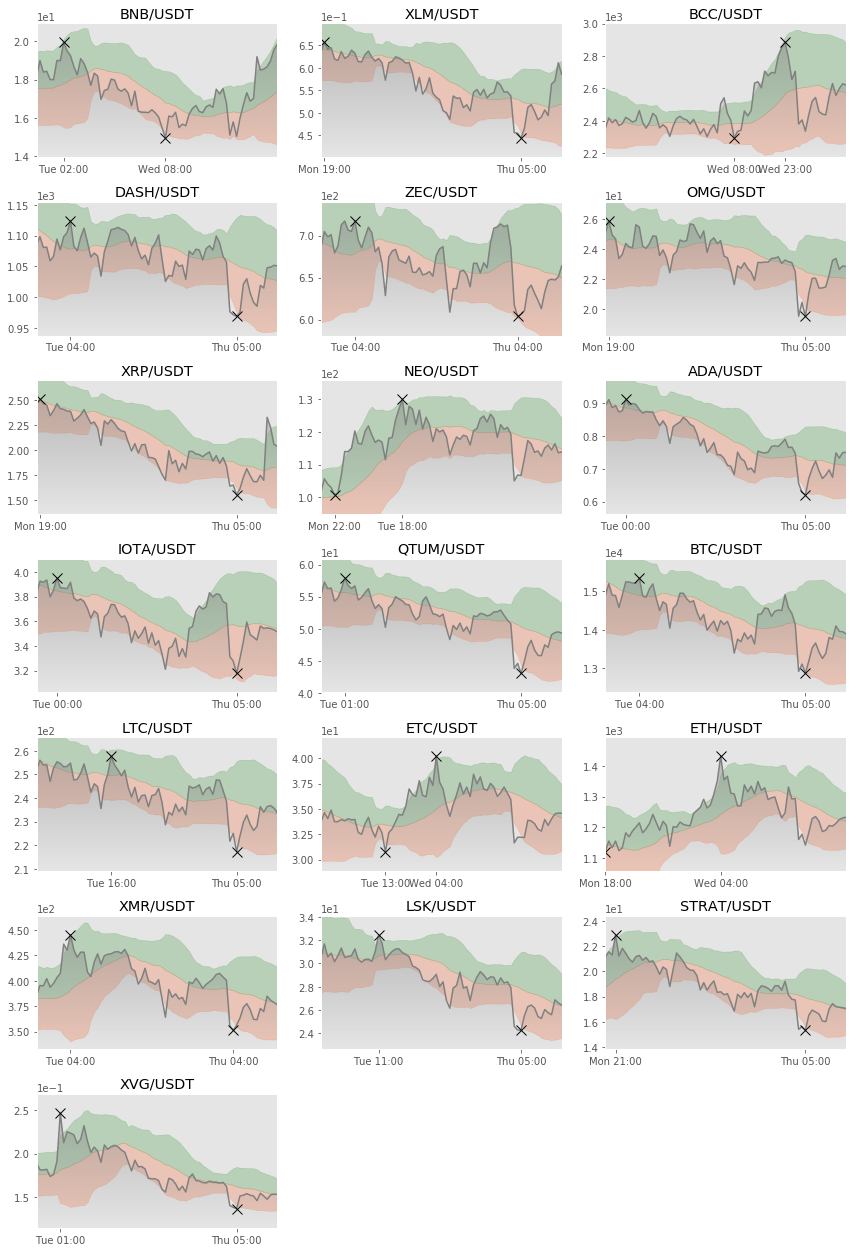

In [329]:
window = 20
reload(plot)

df = utils.to_df(ohlc, 'C')
sma = utils.cut_df(df.rolling(window).mean(), last_window)
sms = utils.cut_df(df.rolling(window).std(), last_window)
bands = (sma + 2 * sms, sma - 2 * sms)
df = utils.cut_df(df, last_window)

rank = lambda sr: -utils._normalize(sr, 'minmax')[-1]
plot.timesr_matrix(df, bands=bands, rank=rank)

## price

    count      mean       std       min       25%       50%       75%  \
0  1368.0 -0.072746  0.296787 -0.811271 -0.273091 -0.049675  0.125339   

        max  
0  0.717054  


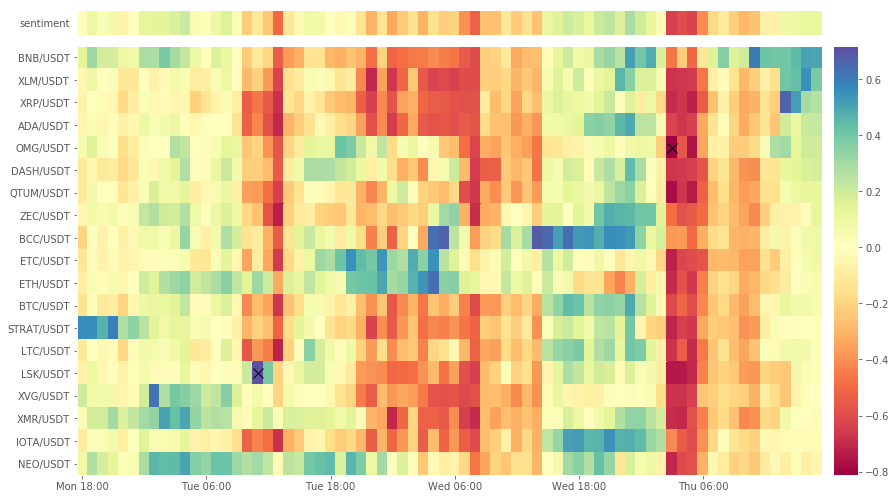

In [209]:
window = 20

df = utils.to_df(ohlc, 'C')
# price relative to mean of previous prices
df = utils.rolling_normalize(df, 'mean', window)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

In [174]:
df = utils.to_df(ohlc, 'C')
df = df.pct_change().dropna()
df.iloc[-1].sort_values()

XLM/USDT     -0.042200
XRP/USDT     -0.010597
LTC/USDT     -0.008273
LSK/USDT     -0.006810
XMR/USDT     -0.006012
IOTA/USDT    -0.004802
BTC/USDT     -0.004251
QTUM/USDT    -0.003690
STRAT/USDT   -0.003440
BCC/USDT     -0.002663
OMG/USDT     -0.001822
XVG/USDT     -0.001530
DASH/USDT    -0.000646
ETC/USDT     -0.000639
ADA/USDT      0.000939
ETH/USDT      0.001942
NEO/USDT      0.002473
BNB/USDT      0.013797
ZEC/USDT      0.019946
Name: 2018-01-11 17:00:00, dtype: float64

    count      mean       std       min       25%       50%       75%  \
0  1368.0  0.000096  0.034961 -0.151471 -0.017763 -0.000803  0.016049   

        max  
0  0.370324  


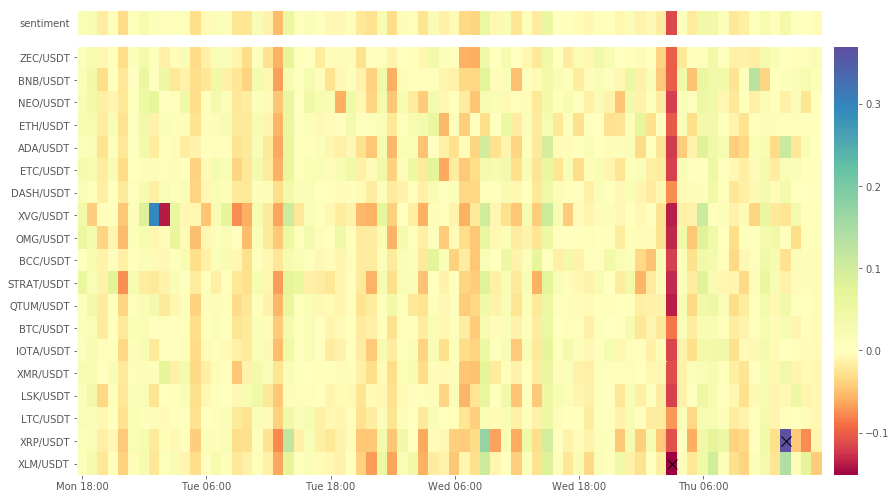

In [175]:
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## volatility

In [177]:
df = utils.to_df(ohlc, 'C')
df = df.std() / df.mean()
df.sort_values()

DASH/USDT     0.064462
BCC/USDT      0.076398
IOTA/USDT     0.076717
BTC/USDT      0.081237
LTC/USDT      0.083032
XMR/USDT      0.087492
QTUM/USDT     0.115264
ETC/USDT      0.120321
ZEC/USDT      0.149106
STRAT/USDT    0.171719
XVG/USDT      0.190308
LSK/USDT      0.196627
OMG/USDT      0.213089
ETH/USDT      0.239302
NEO/USDT      0.262337
XRP/USDT      0.366303
ADA/USDT      0.381352
BNB/USDT      0.470820
XLM/USDT      0.491489
dtype: float64

    count      mean       std       min       25%       50%       75%  \
0  1368.0  0.003129  0.095449 -0.508804 -0.033631 -0.003458  0.027139   

        max  
0  0.863467  


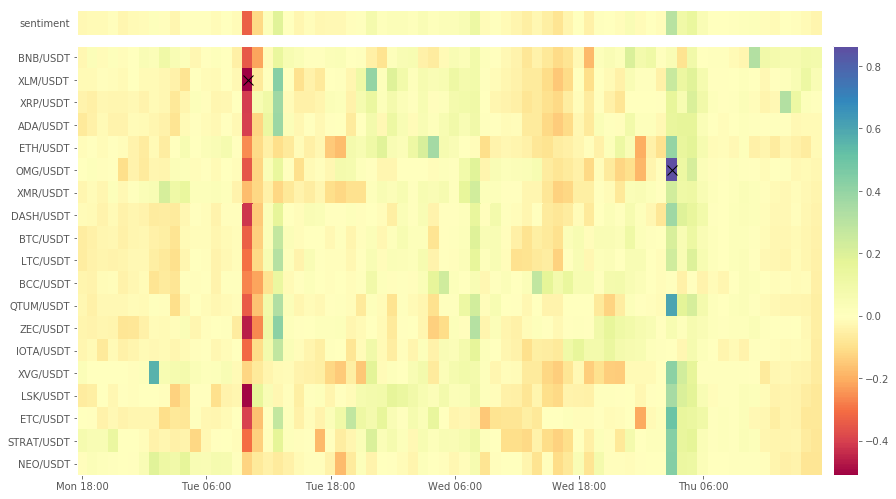

In [178]:
window = 20

df = utils.to_df(ohlc, 'C')
df = df.rolling(window).std()
df = df.pct_change().dropna()
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## volume

    count      mean       std       min       25%       50%       75%      max
0  1368.0 -0.026855  0.273946 -0.691784 -0.191851 -0.085242  0.083845  0.90002


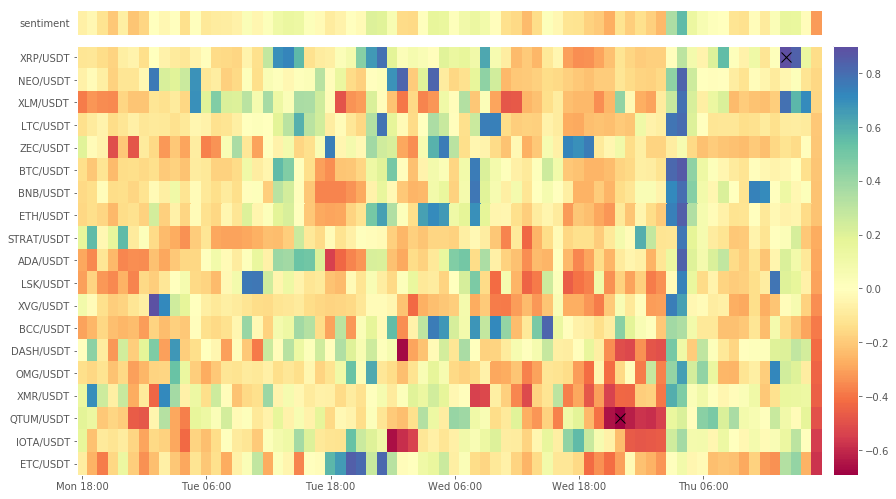

In [179]:
window = 20

df = utils.to_df(ohlc, 'V')
# volume relative to mean of previous volumes
df = utils.rolling_normalize(df, 'mean', window)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# drawdown

## global

In [180]:
stats.dd.now(ohlc)

NEO/USDT      0.130450
ETH/USDT      0.143903
ETC/USDT      0.156203
XMR/USDT      0.157478
BNB/USDT      0.159322
BCC/USDT      0.181395
BTC/USDT      0.191327
ZEC/USDT      0.192028
OMG/USDT      0.212265
DASH/USDT     0.228403
LTC/USDT      0.257873
IOTA/USDT     0.282713
STRAT/USDT    0.303441
LSK/USDT      0.341868
XRP/USDT      0.388407
QTUM/USDT     0.412604
ADA/USDT      0.420949
XLM/USDT      0.423264
XVG/USDT      0.476738
dtype: float64

## local

    count      mean       std       min       25%       50%       75%  \
0  1368.0  0.134313  0.090132  0.002835  0.063917  0.112666  0.182814   

        max  
0  0.507703  


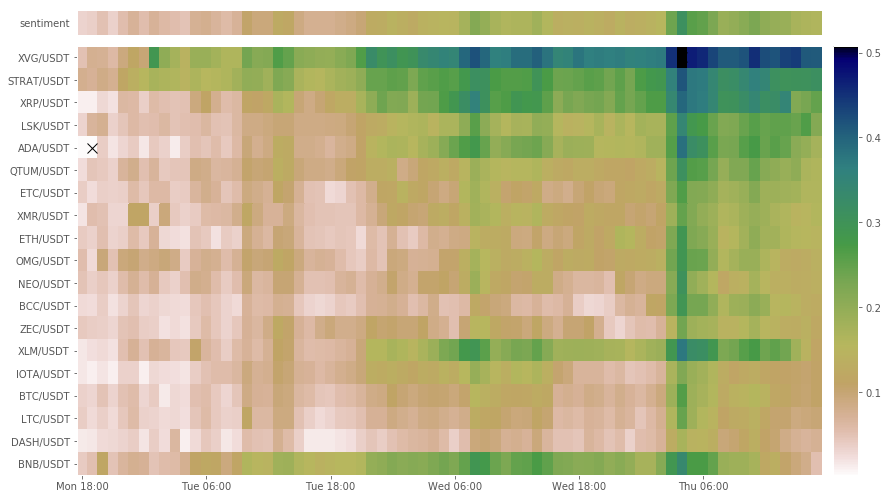

In [182]:
recent_ohlc = utils.cut(ohlc, last_window)
df = stats.dd.from_ohlc(recent_ohlc)

plot.evolution(df, plt.cm.gist_earth_r, rank='last')

# correlation

    count      mean       std       min       25%       50%       75%  \
0  1080.0  0.828123  0.126097  0.194404  0.771932  0.864607  0.915007   

        max  
0  0.991118  


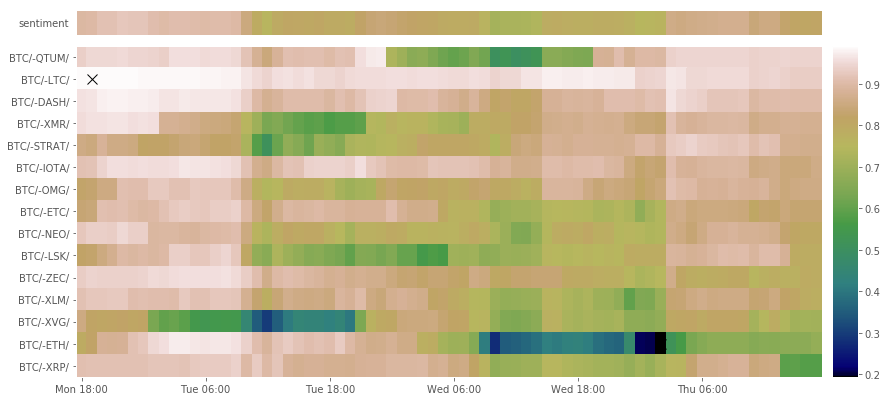

In [184]:
window = 20
base_pair = 'BTC/USDT'

df = utils.to_df(ohlc, 'C').pct_change().dropna()
df = stats.corr.rolling(df, window=window)
regex = re.compile(r'(%s-.+)' % base_pair)
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(%s)' % base_pair.split('/')[1], '', x), df.columns))
df.dropna(inplace=True)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.gist_earth, rank='last')

# depth

    count          mean           std            min            25%       50%  \
0  3800.0  25505.127468  261448.47213 -696975.303924 -137527.295073  7.780029   

             75%           max  
0  161051.175712  1.700639e+06  


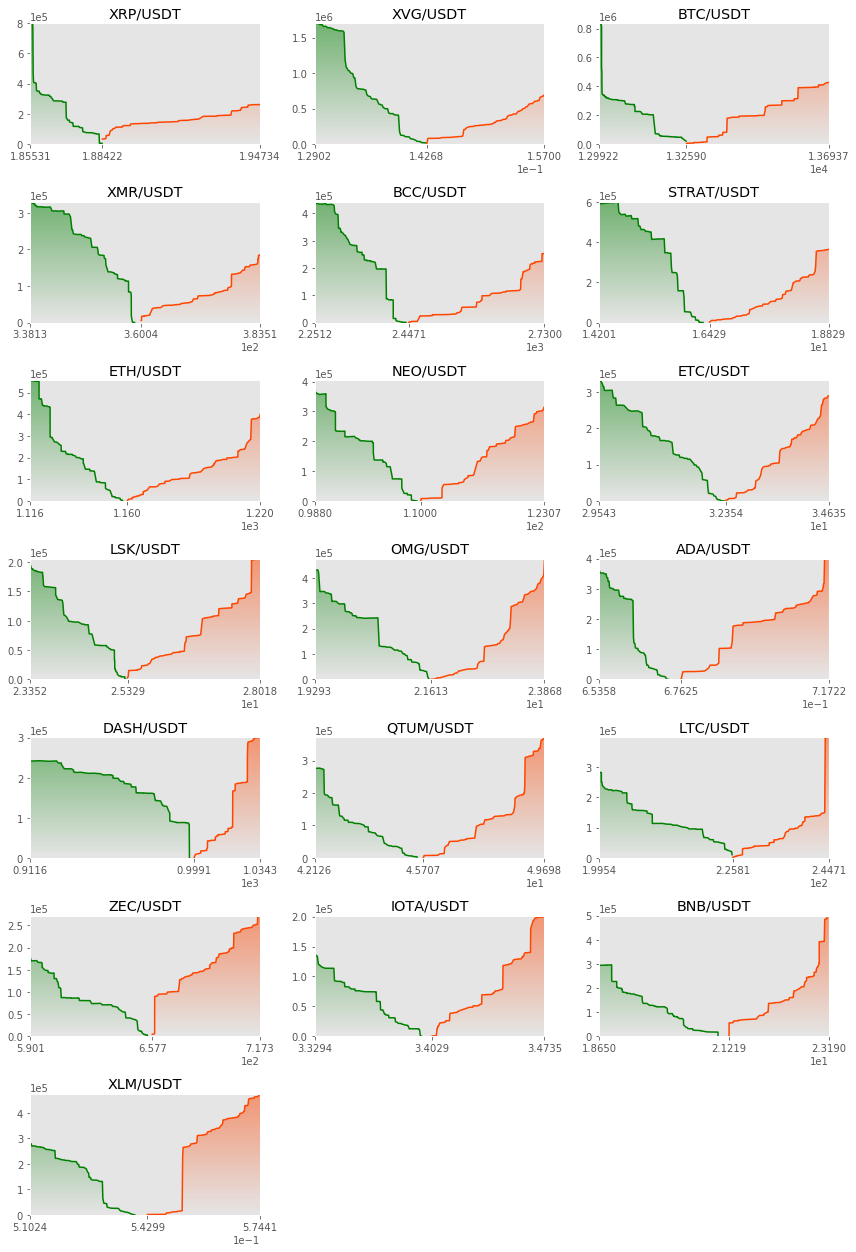

In [327]:
plot.depth(orderbooks, ['green', 'orangered'], rank=lambda sr: 1 - sr.max() / abs(sr.min()))

# anomaly detection

## price

    count      mean       std  min  25%  50%  75%  max
0  1368.0 -0.165936  0.827178 -3.0  0.0  0.0  0.0  3.0


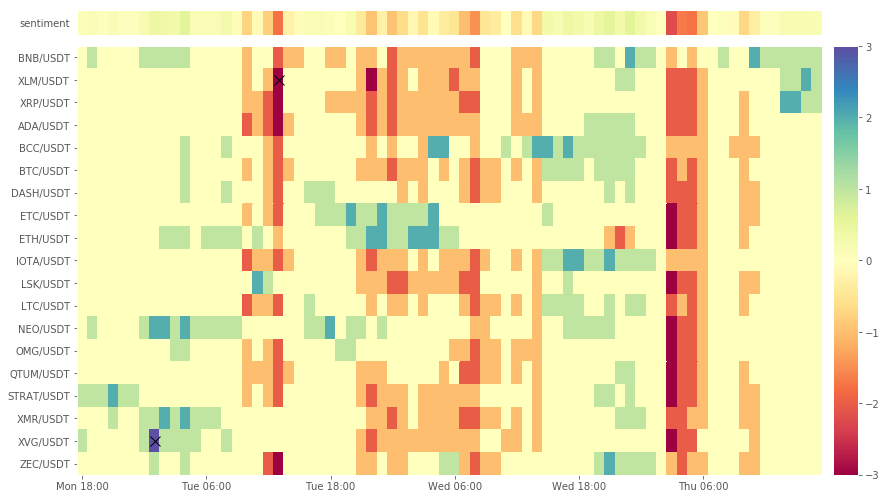

In [203]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'C')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## volume

    count      mean      std  min  25%  50%  75%  max
0  1368.0  0.059211  0.78678 -3.0 -0.0 -0.0 -0.0  4.0


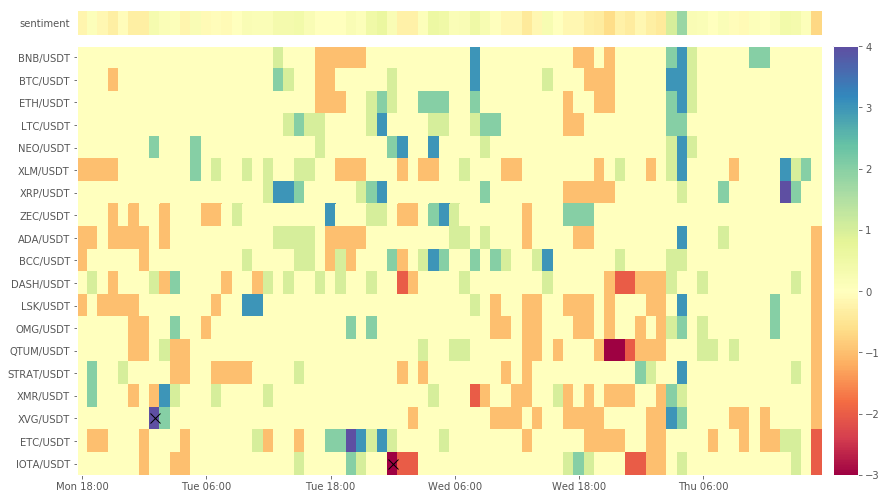

In [202]:
window = 20
levels = [1, 2, 3, 4, 5]

df = utils.to_df(ohlc, 'V')
df = utils.rolling_normalize(df, 'std', window)
df.dropna(inplace=True)
df = utils.classify(df, levels, bipolar=True)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# oscillators

## *RSI*

In [210]:
def RSI(df, window):
    delta = df.diff().dropna()
    up, down = delta * 0, delta * 0
    pos_mask = delta > 0
    neg_mask = delta < 0
    up[pos_mask] = delta[pos_mask]
    down[neg_mask] = -delta[neg_mask]
    up.iloc[window - 1] = up.iloc[:window].mean()
    up = up.iloc[window - 1:]
    down.iloc[window - 1] = down.iloc[:window].mean()
    down = down.iloc[window - 1:]
    rs = up.ewm(com=window - 1, adjust=False).mean() / down.ewm(com=window - 1, adjust=False).mean()
    rsi = 100 - 100 / (1 + rs)
    return rsi.reindex(df.index)

    count      mean       std  min       25%       50%       75%  max
0  1368.0 -0.152364  0.299325 -1.0 -0.335824 -0.162751  0.012562  1.0


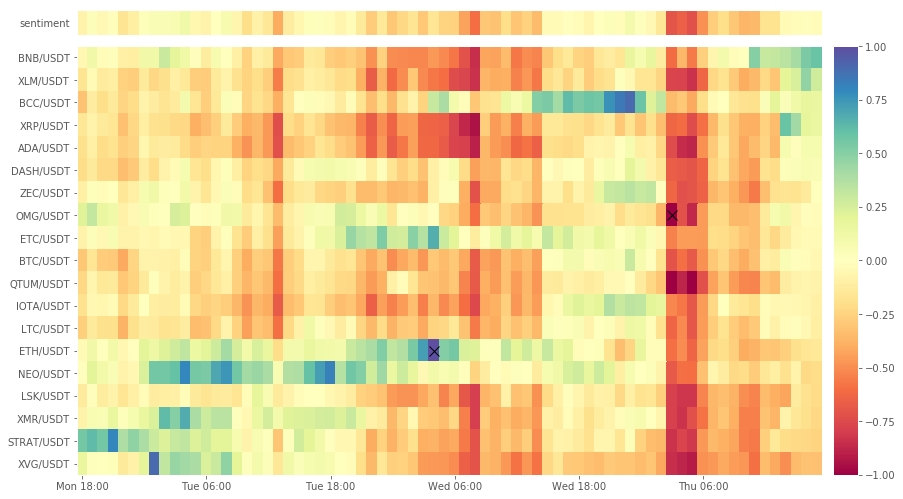

In [280]:
window = 20
oversold = 30
overbought = 70

df = utils.to_df(ohlc, 'C')
df = RSI(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *CCI*

In [215]:
def cci(df, period):
    # (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
    tp_sma = df.rolling(period).mean()
    md = df.rolling(period).apply(lambda a: np.fabs(a - a.mean()).mean())
    return (df - tp_sma) / (.015 * md)

    count     mean       std  min       25%       50%       75%  max
0  1368.0 -0.06544  0.324032 -1.0 -0.267082 -0.061084  0.143065  1.0


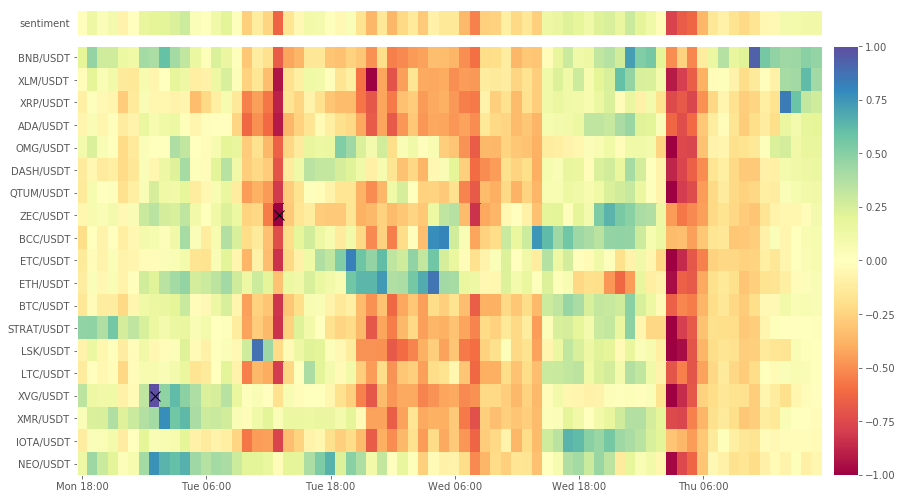

In [279]:
window = 20
oversold = -300
overbought = 300

df = utils.to_df(ohlc, 'C')
df = cci(df, window)
df = utils.trunk(df, [oversold, overbought])
df = utils.rescale(df, [-1, 1])
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

# signals

## *EMA crossover*

In [217]:
def ema_crossover(df, ema_fast, ema_slow):
    fast = df.ewm(span=ema_fast, adjust=False).mean()
    slow = df.ewm(span=ema_slow, adjust=False).mean()
    df = fast - slow
    df[df > 0] = 1
    df[df < 0] = -1
    df = df.fillna(0)
    df = df.diff().dropna()
    pos_mask = df == 2
    neg_mask = df == -2
    df[pos_mask] = 1
    df[neg_mask] = -1
    df[~neg_mask & ~pos_mask] = 0
    return df

    count      mean       std  min  25%  50%  75%  max
0  1368.0  0.000731  0.224666 -1.0  0.0  0.0  0.0  1.0


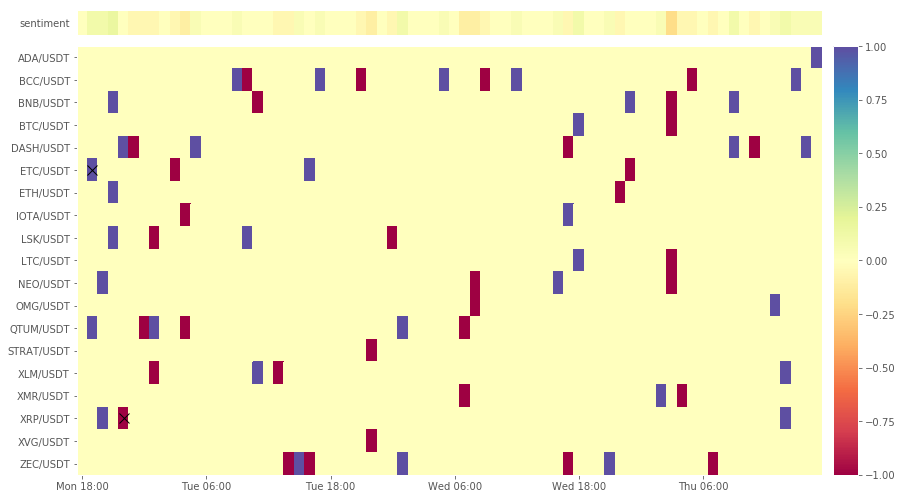

In [228]:
fast_window = 7
slow_window = 25

df = utils.to_df(ohlc, 'M')
df = ema_crossover(df, fast_window, slow_window)
df = utils.cut_df(df, last_window)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

## *BollingerBand*

### How wide is the BB?

In [243]:
def BB(df, window, k):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    BOLU = sma + std * k
    BOLD = sma - std * k
    return BOLD, BOLU

def corridor(BOLD, BOLU):
    return BOLU - BOLD

    count      mean       std       min       25%       50%       75%  \
0  1368.0  0.039766  0.413565 -0.748963 -0.333495 -0.007807  0.433736   

        max  
0  0.787839  


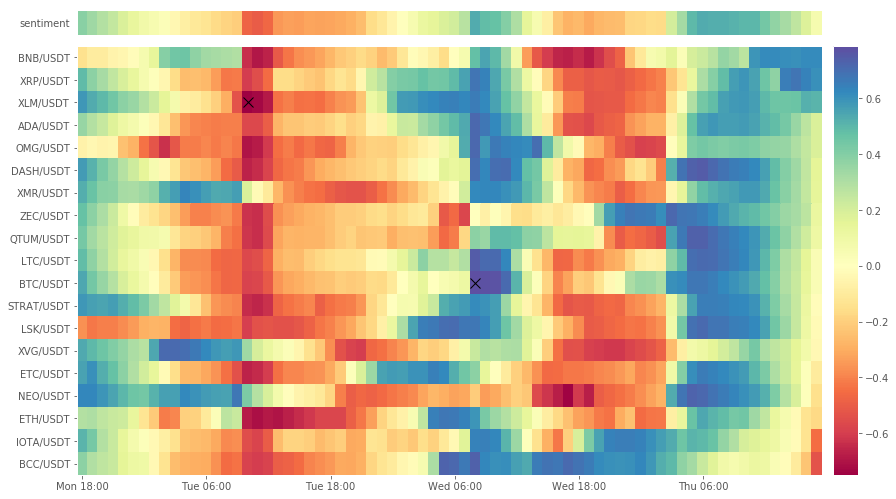

In [276]:
window = 20
k = 2

df = utils.to_df(ohlc, 'C')
df = corridor(*BB(df, window, k)).dropna()
df = utils.rolling_normalize(df, 'mean', window).dropna()
df1 = utils.cut_df(df, last_window)

plot.evolution(df1, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

### Does the price exceed the BB?

    count      mean       std       min       25%       50%       75%  \
0  1368.0 -0.119695  0.559323 -1.796734 -0.483574 -0.096341  0.248993   

        max  
0  1.639099  


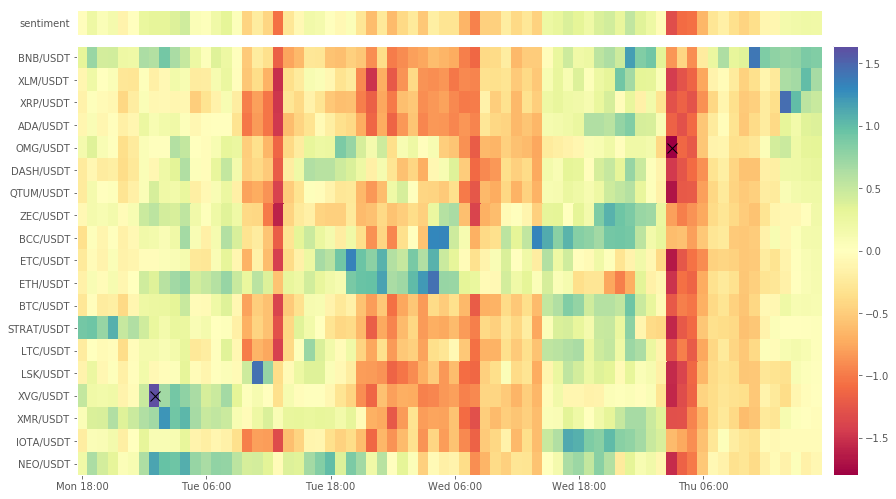

In [283]:
reload(utils)
df = utils.to_df(ohlc, 'C')
df = utils.range_rescale(df, BB(df, window, k), [-1, 1]).dropna()
df2 = utils.cut_df(df, last_window)

plot.evolution(df2, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')

### When to buy/sell?

    count      mean      std  min  25%  50%  75%  max
0  1368.0 -0.046784  0.32117 -1.0 -0.0  0.0 -0.0  1.0


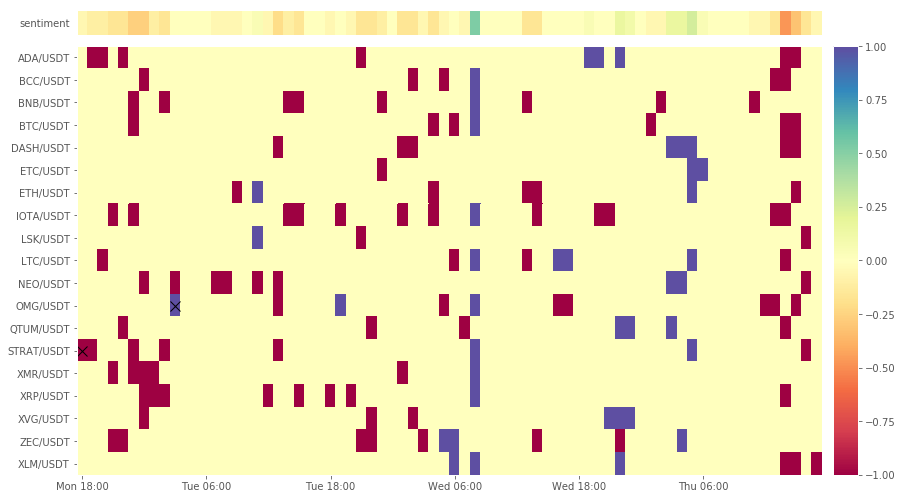

In [287]:
df = utils.combine_scales(df1, df2, 'subtract', [-1, 1])
df = utils.classify(df, [0.9], bipolar=True)

plot.evolution(df, plt.cm.Spectral, plot.midpoint_norm(0), rank='last')